In [6]:
import torch
import argparse
import random
import numpy as np
import pandas as pd
from src.graph_func import graph_construction
from src.utils_func import mk_dir, adata_preprocess, load_ST_file, res_search_fixed_clus, plot_clustering
from src.training import conST_training

import anndata
from sklearn import metrics
import matplotlib.pyplot as plt
import scanpy as sc
import os
import warnings
warnings.filterwarnings('ignore')

In [7]:
parser = argparse.ArgumentParser()
parser.add_argument('--k', type=int, default=10, help='parameter k in spatial graph')
parser.add_argument('--knn_distanceType', type=str, default='euclidean',
                    help='graph distance type: euclidean/cosine/correlation')
parser.add_argument('--epochs', type=int, default=200, help='Number of epochs to train.')
parser.add_argument('--cell_feat_dim', type=int, default=300, help='Dim of PCA')
parser.add_argument('--feat_hidden1', type=int, default=100, help='Dim of DNN hidden 1-layer.')
parser.add_argument('--feat_hidden2', type=int, default=20, help='Dim of DNN hidden 2-layer.')
parser.add_argument('--gcn_hidden1', type=int, default=32, help='Dim of GCN hidden 1-layer.')
parser.add_argument('--gcn_hidden2', type=int, default=8, help='Dim of GCN hidden 2-layer.')
parser.add_argument('--p_drop', type=float, default=0.2, help='Dropout rate.')
parser.add_argument('--use_img', type=bool, default=False, help='Use histology images.')
parser.add_argument('--img_w', type=float, default=0.1, help='Weight of image features.')
parser.add_argument('--use_pretrained', type=bool, default=False, help='Use pretrained weights.')
parser.add_argument('--using_mask', type=bool, default=False, help='Using mask for multi-dataset.')
parser.add_argument('--feat_w', type=float, default=10, help='Weight of DNN loss.')
parser.add_argument('--gcn_w', type=float, default=0.1, help='Weight of GCN loss.')
parser.add_argument('--dec_kl_w', type=float, default=10, help='Weight of DEC loss.')
parser.add_argument('--gcn_lr', type=float, default=0.01, help='Initial GNN learning rate.')
parser.add_argument('--gcn_decay', type=float, default=0.01, help='Initial decay rate.')
parser.add_argument('--dec_cluster_n', type=int, default=10, help='DEC cluster number.')
parser.add_argument('--dec_interval', type=int, default=20, help='DEC interval nnumber.')
parser.add_argument('--dec_tol', type=float, default=0.00, help='DEC tol.')

parser.add_argument('--seed', type=int, default=0, help='random seed')
parser.add_argument('--beta', type=float, default=100, help='beta value for l2c')
parser.add_argument('--cont_l2l', type=float, default=0.3, help='Weight of local contrastive learning loss.')
parser.add_argument('--cont_l2c', type=float, default= 0.1, help='Weight of context contrastive learning loss.')
parser.add_argument('--cont_l2g', type=float, default= 0.1, help='Weight of global contrastive learning loss.')

parser.add_argument('--edge_drop_p1', type=float, default=0.1, help='drop rate of adjacent matrix of the first view')
parser.add_argument('--edge_drop_p2', type=float, default=0.1, help='drop rate of adjacent matrix of the second view')
parser.add_argument('--node_drop_p1', type=float, default=0.2, help='drop rate of node features of the first view')
parser.add_argument('--node_drop_p2', type=float, default=0.3, help='drop rate of node features of the second view')

# ______________ Eval clustering Setting ______________
parser.add_argument('--eval_resolution', type=int, default=1, help='Eval cluster number.')
parser.add_argument('--eval_graph_n', type=int, default=20, help='Eval graph kN tol.') 

params =  parser.parse_args(args=['--k', '20', '--knn_distanceType', 'euclidean', '--epochs', '200'])

np.random.seed(params.seed)
torch.manual_seed(params.seed)
torch.cuda.manual_seed(params.seed)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('Using device: ' + device)
params.device = device

Using device: cuda:0


In [8]:

adata_h5 = sc.read_h5ad('/home/workspace2/zhaofangyuan/data_h5ad/without_groundtruth/Visium_demon/V1_Mouse_Brain_Sagittal_Posterior_Section_2.h5ad')
adata_X = adata_preprocess(adata_h5, min_cells=5, pca_n_comps=params.cell_feat_dim)
graph_dict = graph_construction(adata_h5.obsm['spatial'], adata_h5.shape[0], params)
np.save('./input/V1_Mouse_Brain_Sagittal_Posterior_Section_2/adatax.npy', adata_X)
np.save('./input/V1_Mouse_Brain_Sagittal_Posterior_Section_2/graphdict.npy', graph_dict, allow_pickle = True)


===== Preprocessing Data 


In [9]:
# set seed before every run
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
seed_torch(params.seed)

In [10]:
data_name = 'V1_Mouse_Brain_Sagittal_Posterior_Section_2'
save_root = './output/spatialLIBD/'

params.save_path = mk_dir(f'{save_root}/{data_name}/conST')

adata_h5 = sc.read_h5ad('/home/workspace2/zhaofangyuan/data_h5ad/without_groundtruth/Visium_demon/V1_Mouse_Brain_Sagittal_Posterior_Section_2.h5ad')

adata_X = np.load('./input/V1_Mouse_Brain_Sagittal_Posterior_Section_2/adatax.npy')
graph_dict = np.load('./input/V1_Mouse_Brain_Sagittal_Posterior_Section_2/graphdict.npy',  allow_pickle = True).item()
params.cell_num = adata_h5.shape[0]

In [11]:

def get_refine(sample_id, pred, dis, shape="hexagon"):
    refined_pred=[]
    pred=pd.DataFrame({"pred": pred}, index=sample_id)
    dis_df=pd.DataFrame(dis, index=sample_id, columns=sample_id)
    if shape=="hexagon":
        num_nbs=6 
    elif shape=="square":
        num_nbs=4
    else:
        print("Shape not recongized, shape='hexagon' for Visium data, 'square' for ST data.")
    for i in range(len(sample_id)):
        index=sample_id[i]
        dis_tmp=dis_df.loc[index, :].sort_values(ascending=False)
        nbs=dis_tmp[0:num_nbs+1]
        nbs_pred=pred.loc[nbs.index, "pred"]
        self_pred=pred.loc[index, "pred"]
        v_c=nbs_pred.value_counts()
        if (v_c.loc[self_pred]<num_nbs/2) and (np.max(v_c)>num_nbs/2):
            refined_pred.append(v_c.idxmax())
        else:           
            refined_pred.append(self_pred)
    return refined_pred

0


Pretraining stage:  |################| 200 / 200 | Left time: 0.00 mins| Loss: 161.0520retraining stage:  |##              | 32 / 200 | Left time: 0.11 mins| Loss: 173.7898Pretraining stage:  |##              | 34 / 200 | Left time: 0.08 mins| Loss: 173.8125Pretraining stage:  |###             | 49 / 200 | Left time: 0.05 mins| Loss: 171.3275Pretraining stage:  |#######         | 95 / 200 | Left time: 0.04 mins| Loss: 167.2299Pretraining stage:  |##########      | 129 / 200 | Left time: 0.02 mins| Loss: 165.3062Pretraining stage:  |##########      | 136 / 200 | Left time: 0.03 mins| Loss: 166.3362Pretraining stage:  |############    | 160 / 200 | Left time: 0.02 mins| Loss: 164.0550Pretraining stage:  |############    | 161 / 200 | Left time: 0.02 mins| Loss: 164.9326Pretraining stage:  |#############   | 171 / 200 | Left time: 0.02 mins| Loss: 163.2785Pretraining stage:  |##############  | 185 / 200 | Left time: 0.01 mins| Loss: 165.5330Pretraining stage:  |############### | 195 / 200

0.18999999999999997


Pretraining stage:  |                | 4 / 200 | Left time: 0.08 mins| Loss: 184.1002

1


Pretraining stage:  |################| 200 / 200 | Left time: 0.00 mins| Loss: 161.5692Pretraining stage:  |##########      | 134 / 200 | Left time: 0.03 mins| Loss: 165.5101
Major training stage:  |################| 200 / 200 | Loss: 3.4381


0.22999999999999998


Pretraining stage:  |                | 8 / 200 | Left time: 0.06 mins| Loss: 180.8097

2


Pretraining stage:  |################| 200 / 200 | Left time: 0.00 mins| Loss: 163.7016
Major training stage:  |################| 200 / 200 | Loss: 3.4945


0.22999999999999998


Pretraining stage:  |                | 5 / 200 | Left time: 0.07 mins| Loss: 182.6883

3


Pretraining stage:  |################| 200 / 200 | Left time: 0.00 mins| Loss: 162.2105
Major training stage:  |################| 200 / 200 | Loss: 3.4752


0.44999999999999996


Pretraining stage:  |                | 5 / 200 | Left time: 0.08 mins| Loss: 182.6388

4


Pretraining stage:  |################| 200 / 200 | Left time: 0.00 mins| Loss: 162.4932retraining stage:  |#               | 15 / 200 | Left time: 0.08 mins| Loss: 177.4224Pretraining stage:  |###             | 39 / 200 | Left time: 0.07 mins| Loss: 172.7720Pretraining stage:  |###             | 44 / 200 | Left time: 0.06 mins| Loss: 172.0872Pretraining stage:  |####            | 56 / 200 | Left time: 0.14 mins| Loss: 170.1009Pretraining stage:  |######          | 79 / 200 | Left time: 0.05 mins| Loss: 169.4784Pretraining stage:  |#######         | 96 / 200 | Left time: 0.04 mins| Loss: 168.8843Pretraining stage:  |#########       | 123 / 200 | Left time: 0.03 mins| Loss: 166.3862Pretraining stage:  |##########      | 137 / 200 | Left time: 0.03 mins| Loss: 164.3123Pretraining stage:  |#############   | 174 / 200 | Left time: 0.01 mins| Loss: 164.7256Pretraining stage:  |############### | 188 / 200 | Left time: 0.01 mins| Loss: 164.6638Pretraining stage:  |############### | 196 / 200 |

0.5299999999999999


Pretraining stage:  |                | 6 / 200 | Left time: 0.07 mins| Loss: 182.8244

5


Pretraining stage:  |################| 200 / 200 | Left time: 0.00 mins| Loss: 162.1226retraining stage:  |##              | 37 / 200 | Left time: 0.06 mins| Loss: 173.2853Pretraining stage:  |###             | 40 / 200 | Left time: 0.09 mins| Loss: 172.8041Pretraining stage:  |####            | 51 / 200 | Left time: 0.05 mins| Loss: 172.1405Pretraining stage:  |####            | 57 / 200 | Left time: 0.10 mins| Loss: 170.7351Pretraining stage:  |#####           | 73 / 200 | Left time: 0.04 mins| Loss: 169.9940Pretraining stage:  |###########     | 141 / 200 | Left time: 0.02 mins| Loss: 166.3735Pretraining stage:  |##############  | 177 / 200 | Left time: 0.01 mins| Loss: 162.7982Pretraining stage:  |##############  | 181 / 200 | Left time: 0.01 mins| Loss: 164.0065Pretraining stage:  |##############  | 183 / 200 | Left time: 0.01 mins| Loss: 163.7677Pretraining stage:  |############### | 188 / 200 | Left time: 0.00 mins| Loss: 161.9497
Major training stage:  |################| 200 / 

0.42999999999999994


Pretraining stage:  |                | 5 / 200 | Left time: 0.07 mins| Loss: 182.7517

6


Pretraining stage:  |################| 200 / 200 | Left time: 0.00 mins| Loss: 162.3590retraining stage:  |####            | 62 / 200 | Left time: 0.05 mins| Loss: 170.3699Pretraining stage:  |########        | 107 / 200 | Left time: 0.03 mins| Loss: 166.4605Pretraining stage:  |########        | 108 / 200 | Left time: 0.05 mins| Loss: 168.3966Pretraining stage:  |##########      | 135 / 200 | Left time: 0.06 mins| Loss: 164.4891Pretraining stage:  |###########     | 140 / 200 | Left time: 0.02 mins| Loss: 165.2624Pretraining stage:  |############    | 153 / 200 | Left time: 0.04 mins| Loss: 163.5876
Major training stage:  |################| 200 / 200 | Loss: 3.5035


0.6099999999999999


Pretraining stage:  |                | 4 / 200 | Left time: 0.07 mins| Loss: 184.0924

7


Pretraining stage:  |################| 200 / 200 | Left time: 0.00 mins| Loss: 163.0871Pretraining stage:  |############### | 197 / 200 | Left time: 0.00 mins| Loss: 163.1776
Major training stage:  |################| 200 / 200 | Loss: 3.4703


0.57


Pretraining stage:  |                | 5 / 200 | Left time: 0.07 mins| Loss: 182.6995

8


Pretraining stage:  |################| 200 / 200 | Left time: 0.00 mins| Loss: 163.9671etraining stage:  |                | 9 / 200 | Left time: 0.06 mins| Loss: 179.6957Pretraining stage:  |###             | 38 / 200 | Left time: 0.06 mins| Loss: 173.8579Pretraining stage:  |####            | 52 / 200 | Left time: 0.08 mins| Loss: 171.1483Pretraining stage:  |##########      | 131 / 200 | Left time: 0.04 mins| Loss: 166.1433Pretraining stage:  |###########     | 140 / 200 | Left time: 0.02 mins| Loss: 165.1248Pretraining stage:  |#############   | 167 / 200 | Left time: 0.01 mins| Loss: 164.1913Pretraining stage:  |#############   | 172 / 200 | Left time: 0.01 mins| Loss: 163.6326Pretraining stage:  |##############  | 179 / 200 | Left time: 0.01 mins| Loss: 163.1977
Major training stage:  |################| 200 / 200 | Loss: 3.3409


0.6299999999999999


Pretraining stage:  |                | 4 / 200 | Left time: 0.08 mins| Loss: 183.9372

9


Pretraining stage:  |################| 200 / 200 | Left time: 0.00 mins| Loss: 161.8586retraining stage:  |                | 12 / 200 | Left time: 0.10 mins| Loss: 178.2244Pretraining stage:  |#               | 14 / 200 | Left time: 0.08 mins| Loss: 177.7002Pretraining stage:  |#               | 17 / 200 | Left time: 0.07 mins| Loss: 176.4224Pretraining stage:  |#               | 18 / 200 | Left time: 0.07 mins| Loss: 176.7485Pretraining stage:  |#####           | 66 / 200 | Left time: 0.05 mins| Loss: 169.4035Pretraining stage:  |#####           | 67 / 200 | Left time: 0.05 mins| Loss: 169.1858Pretraining stage:  |#####           | 69 / 200 | Left time: 0.05 mins| Loss: 170.0861Pretraining stage:  |######          | 81 / 200 | Left time: 0.05 mins| Loss: 169.3182
Major training stage:  |################| 200 / 200 | Loss: 3.3436


0.7299999999999999


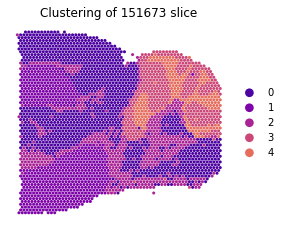

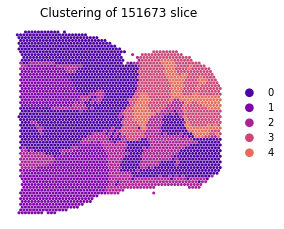

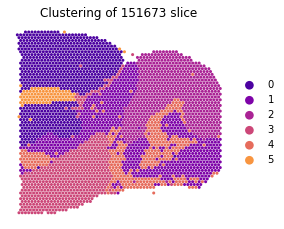

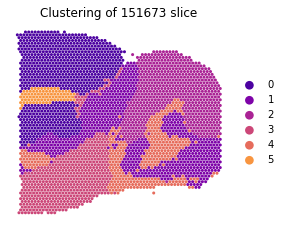

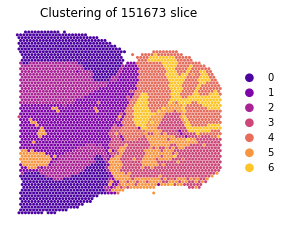

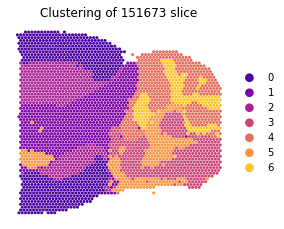

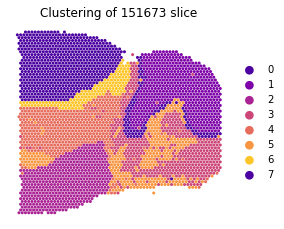

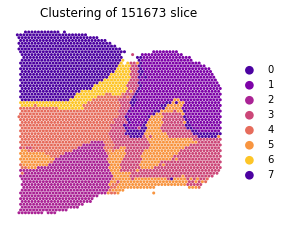

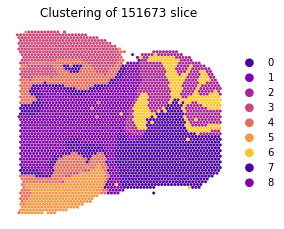

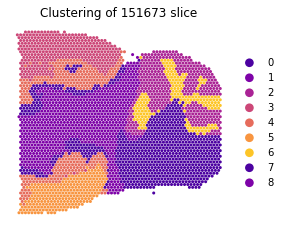

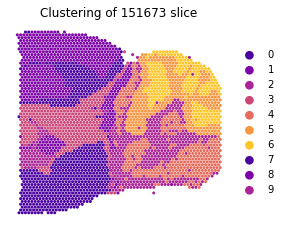

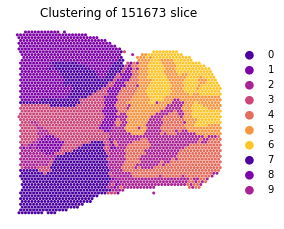

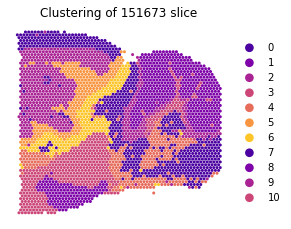

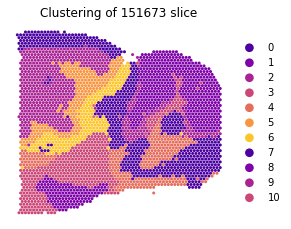

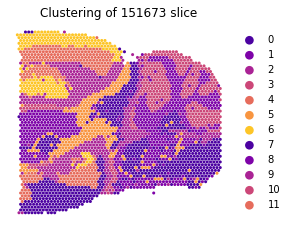

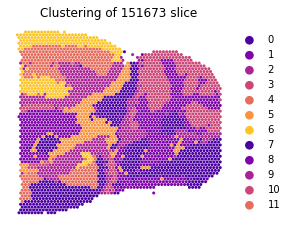

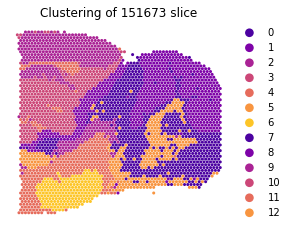

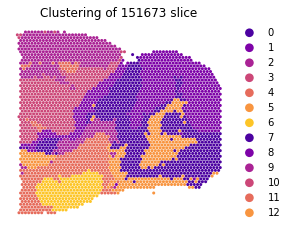

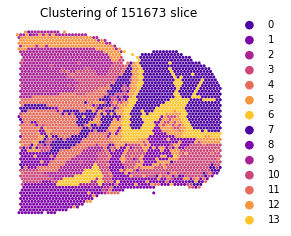

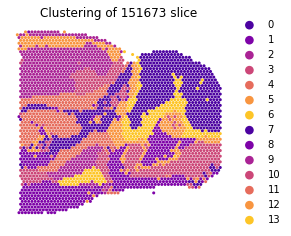

In [12]:

for j in range(10):
    print(j)
    n_clusters_list = [5,6,7,8,9,10,11,12,13,14]
    if params.use_img:
        img_transformed = np.load('./MAE-pytorch/extracted_feature.npy')
        img_transformed = (img_transformed - img_transformed.mean()) / img_transformed.std() * adata_X.std() + adata_X.mean()
        conST_net = conST_training(adata_X, graph_dict, params, n_clusters_list[j], img_transformed)
    else:
        conST_net = conST_training(adata_X, graph_dict, params, n_clusters_list[j])
    if params.use_pretrained:
        conST_net.load_model('conST_151674.pth')
    else:
        conST_net.pretraining()
        conST_net.major_training()

    conST_embedding = conST_net.get_embedding()

    np.save(f'{params.save_path}/conST_result.npy', conST_embedding)
    # clustering
    adata_conST = anndata.AnnData(conST_embedding)
    adata_conST.uns['spatial'] = adata_h5.uns['spatial']
    adata_conST.obsm['spatial'] = adata_h5.obsm['spatial']

    sc.pp.neighbors(adata_conST, n_neighbors=params.eval_graph_n)

    eval_resolution = res_search_fixed_clus(adata_conST, n_clusters_list[j])
    print(eval_resolution)
    cluster_key = "conST_leiden"
    sc.tl.leiden(adata_conST, key_added=cluster_key, resolution=eval_resolution)

    # plotting
    savepath = f'{params.save_path}/conST_leiden_plot_{j+1}.jpg'
    plot_clustering(adata_conST, cluster_key, savepath = savepath)

   
    adata_h5.obs['conST_{}'.format(j+1)] = adata_conST.obs[cluster_key]


    #refined
    index = np.arange(start=0, stop=adata_X.shape[0]).tolist()
    index = [str(x) for x in index]
    
    dis = graph_dict['adj_norm'].to_dense().numpy() + np.eye(graph_dict['adj_norm'].shape[0])
    refine = get_refine(sample_id = index, pred = adata_conST.obs['leiden'].tolist(), dis=dis)
    adata_conST.obs['refine'] = refine

    cluster_key = 'refine'
    savepath = f'{params.save_path}/conST_leiden_plot_refined_{j+1}.jpg'
    plot_clustering(adata_conST, cluster_key, savepath = savepath)

    adata_h5.obs['conST_refined_{}'.format(j+1)] = adata_conST.obs['refine']



adata_h5.write(f'{save_root}/V1_Mouse_Brain_Sagittal_Posterior_Section_2/conST_V1_Mouse_Brain_Sagittal_Posterior_Section_2(resolution).h5ad')

In [13]:
adata_h5

# df_meta = pd.read_csv(f'{data_root}/{data_name}/metadata.tsv', sep='\t')
# df_meta['conST_refine'] = adata_conST.obs['refine'].tolist()
# df_meta.to_csv(f'{params.save_path}/metadata.tsv', sep='\t', index=False)
# df_meta = df_meta[~pd.isnull(df_meta['layer_guess'])]
# ARI = metrics.adjusted_rand_score(df_meta['layer_guess'], df_meta['conST_refine'])
# print('===== Project: {} refined ARI score: {:.3f}'.format(data_name, ARI))

AnnData object with n_obs × n_vars = 3289 × 32285
    obs: 'in_tissue', 'array_row', 'array_col', 'conST_1', 'conST_refined_1', 'conST_2', 'conST_refined_2', 'conST_3', 'conST_refined_3', 'conST_4', 'conST_refined_4', 'conST_5', 'conST_refined_5', 'conST_6', 'conST_refined_6', 'conST_7', 'conST_refined_7', 'conST_8', 'conST_refined_8', 'conST_9', 'conST_refined_9', 'conST_10', 'conST_refined_10'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

# 